# Classifying Potentially Dangerous Asteroids
## Dane Lacey, Julien Schwalbe, Stasiani-Diana Tzouvara, Ahmet Gueler

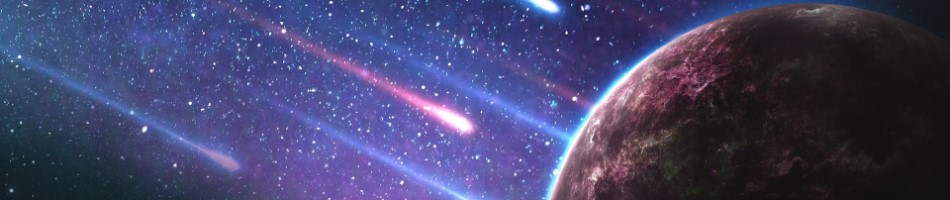

In [1]:
from IPython.display import Image
Image(filename = "dataset-cover.jpg", width=1000, height=1000)

# Vocabulary
### PHO (Potentially Hazardous Objects)
### BO (Benign Objects)  

# Data Sets
### - orbits.csv and impacts.csv, from https://www.kaggle.com/datasets/nasa/asteroid-impacts
### - orbits.csv $:=$ PHO $\cup$ BO
### - orbits.csv measures orbits around the SUN
#### &emsp; - 15 features, 15635 orbits
### - impacts.csv $:=$ PHO
#### &emsp; - 11 different features, 683 PHO

In [2]:
# %pip install numpy
# %pip install pandas
# %pip install tensorflow
# %pip install sklearn
# %pip install imbalanced-learn

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype
import unicodedata

In [4]:
orbits_df = pd.read_csv("orbits.csv", encoding = 'utf-8')
unicode_adjusted_names = {}
for asteroid_idx in orbits_df.index:
    unicode_adjusted_names[asteroid_idx] = unicodedata.normalize("NFKD", orbits_df.iloc[asteroid_idx]["Object Name"])
    
orbits_df["Object Name"] = unicode_adjusted_names.values()
orbits_df.head()

,Object Name,Object Classification,Epoch (TDB),Orbit Axis (AU),Orbit Eccentricity,Orbit Inclination (deg),Perihelion Argument (deg),Node Longitude (deg),Mean Anomoly (deg),Perihelion Distance (AU),Aphelion Distance (AU),Orbital Period (yr),Minimum Orbit Intersection Distance (AU),Orbital Reference,Asteroid Magnitude
0,433 Eros,Amor Asteroid,57800,1.4579,0.2226,10.8277,178.8050,304.3265,319.3111,1.1335,1.78,1.76,0.1492,598,11.16
1,719 Albert,Amor Asteroid,57800,2.6385,0.5479,11.5822,156.1409,183.9204,224.5535,1.1928,4.08,4.29,0.2004,78,15.50
2,887 Alinda,Amor Asteroid,57800,2.4787,0.5671,9.3561,350.3482,110.5444,351.3730,1.0731,3.88,3.90,0.0925,188,13.40
3,1036 Ganymed,Amor Asteroid,57800,2.6628,0.5338,26.6929,132.4690,215.5551,92.5640,1.2413,4.08,4.35,0.3421,597,9.45
4,1221 Amor,Amor Asteroid,57800,1.9191,0.4356,11.8795,26.6572,171.3448,313.7379,1.0832,2.76,2.66,0.1068,70,17.70


In [5]:
PHO_df = pd.read_csv("impacts.csv", encoding = 'utf-8')
PHO_df.head()

,Object Name,Period Start,Period End,Possible Impacts,Cumulative Impact Probability,Asteroid Velocity,Asteroid Magnitude,Asteroid Diameter (km),Cumulative Palermo Scale,Maximum Palermo Scale,Maximum Torino Scale
0,2006 WP1,2017,2017,1,5.200000e-09,17.77,28.3,0.007,-8.31,-8.31,0
1,2013 YB,2017,2046,23,7.600000e-05,8.98,31.4,0.002,-6.60,-6.96,0
2,2008 US,2017,2062,30,1.600000e-05,18.33,31.4,0.002,-6.48,-6.87,0
3,2010 VR139,2017,2076,24,2.000000e-07,4.99,26.7,0.016,-6.83,-6.95,0
4,2015 ME131,2017,2096,85,2.300000e-08,19.46,19.2,0.497,-3.85,-4.30,0


In [6]:
print(orbits_df.columns)

Index(['Object Name', 'Object Classification', 'Epoch (TDB)',
       'Orbit Axis (AU)', 'Orbit Eccentricity', 'Orbit Inclination (deg)',
       'Perihelion Argument (deg)', 'Node Longitude (deg)',
       'Mean Anomoly (deg)', 'Perihelion Distance (AU)',
       'Aphelion Distance (AU)', 'Orbital Period (yr)',
       'Minimum Orbit Intersection Distance (AU)', 'Orbital Reference',
       'Asteroid Magnitude'],
      dtype='object')


In [7]:
# Convert to SI units
grav_const = 1/(6.674384 * 10**11) # units [m^3 / (kg * s^2)]
mass_sun = 1.988500 * 10**30 # units [kg]
AU_to_m_conversion = 149597870691
year_to_s_conversion = 31536000

# Convert distances to m
orbits_df["Aphelion Distance (m)"] = orbits_df["Aphelion Distance (AU)"] * AU_to_m_conversion
# orbits_df.drop(["Aphelion Distance (AU)"], 1, inplace=True)
orbits_df["Perihelion Distance (m)"] = orbits_df["Perihelion Distance (AU)"] * AU_to_m_conversion
# orbits_df.drop(["Perihelion Distance (AU)"], 1, inplace=True)
orbits_df["Orbit Axis (m)"] = orbits_df["Orbit Axis (AU)"] * AU_to_m_conversion
# orbits_df.drop(["Orbit Axis (AU)"], 1, inplace=True)
orbits_df["Orbital Period (s)"] = orbits_df["Orbital Period (yr)"] * year_to_s_conversion
# orbits_df.drop(["Orbital Period (yr)"], 1, inplace=True)

In [8]:
 # https://sites.uni.edu/morgans/astro/course/Notes/section1/math3.html

In [9]:
# TODO: Verify validity of calculations
# need to calculate speed N and specific angular momentum H...

avg_distance_from_sun = (orbits_df["Orbital Period (s)"])**(2/3) # units [m]

orbits_df["Avg. Mean Speed (m/s)"] = grav_const * mass_sun * ((2 / orbits_df["Orbital Period (s)"]) - (1 / orbits_df["Orbit Axis (m)"]))# units [m / s]
orbits_df["Specific Ang. Momentum (m^2/s)"] = orbits_df["Orbit Axis (m)"] * (grav_const * mass_sun / orbits_df["Orbit Axis (m)"])**(.5) # units [m^2 / s]

In [10]:
orbits_df.head()

,Object Name,Object Classification,Epoch (TDB),Orbit Axis (AU),Orbit Eccentricity,Orbit Inclination (deg),Perihelion Argument (deg),Node Longitude (deg),Mean Anomoly (deg),Perihelion Distance (AU),...,Orbital Period (yr),Minimum Orbit Intersection Distance (AU),Orbital Reference,Asteroid Magnitude,Aphelion Distance (m),Perihelion Distance (m),Orbit Axis (m),Orbital Period (s),Avg. Mean Speed (m/s),Specific Ang. Momentum (m^2/s)
0,433 Eros,Amor Asteroid,57800,1.4579,0.2226,10.8277,178.8050,304.3265,319.3111,1.1335,...,1.76,0.1492,598,11.16,2.662842e+11,1.695692e+11,2.180987e+11,55503360.0,1.073420e+11,8.060905e+14
1,719 Albert,Amor Asteroid,57800,2.6385,0.5479,11.5822,156.1409,183.9204,224.5535,1.1928,...,4.29,0.2004,78,15.50,6.103593e+11,1.784403e+11,3.947140e+11,135289440.0,4.403582e+10,1.084422e+15
2,887 Alinda,Amor Asteroid,57800,2.4787,0.5671,9.3561,350.3482,110.5444,351.3730,1.0731,...,3.90,0.0925,188,13.40,5.804397e+11,1.605335e+11,3.708082e+11,122990400.0,4.843967e+10,1.051071e+15
3,1036 Ganymed,Amor Asteroid,57800,2.6628,0.5338,26.6929,132.4690,215.5551,92.5640,1.2413,...,4.35,0.3421,597,9.45,6.103593e+11,1.856958e+11,3.983492e+11,137181600.0,4.342839e+10,1.089405e+15
4,1221 Amor,Amor Asteroid,57800,1.9191,0.4356,11.8795,26.6572,171.3448,313.7379,1.0832,...,2.66,0.1068,70,17.70,4.128901e+11,1.620444e+11,2.870933e+11,83885760.0,7.102197e+10,9.248445e+14


In [11]:
targets_dict = {}
all_PHO = PHO_df["Object Name"]
all_asteroids = orbits_df["Object Name"]

# Create correspondence between datasets, i.e. generate targets
for asteroid_idx in all_asteroids.index:
    # Initialize dictionary entry to zero
    targets_dict[all_asteroids[asteroid_idx]] = 0

    current_asteroid = all_asteroids[asteroid_idx].split()
    current_asteroid = [codename.replace("(", "").replace(")","") for codename in current_asteroid]

    for PHO_idx in all_PHO.index:
        current_PHO = all_PHO[PHO_idx]
        year_PHO = (current_PHO.split())[0]
        codename_PHO = (current_PHO.split())[1]
        if (year_PHO in current_asteroid) and (codename_PHO in current_asteroid):
            # If this PHO corresponds to an asteroid, change target 0 -> 1
            targets_dict[all_asteroids[asteroid_idx]] = 1
            
        # We have detected the correspondence for this asteroid. Move on
        continue

targets = pd.Series(targets_dict)

In [12]:
# Sanity check
print(len(all_PHO))
print(sum(targets))

print(len(targets))
print(len(all_asteroids))

683
679
15635
15635


In [13]:
# Isolate features of interest. TODO: give reasoning! Keplerian elements, etc...

features_of_interest = ["Orbit Axis (m)", "Orbit Eccentricity", "Orbit Inclination (deg)", "Avg. Mean Speed (m/s)", "Specific Ang. Momentum (m^2/s)"]
orbits_df.drop(orbits_df.columns.difference(features_of_interest), 1, inplace=True)

C:\Users\danec\AppData\Local\Temp/ipykernel_10896/1846278508.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  orbits_df.drop(orbits_df.columns.difference(features_of_interest), 1, inplace=True)


In [14]:
# Following the 70/30 rule for training/validation
train_df, test_df = train_test_split(orbits_df, test_size=0.35)

train_df.head()

,Orbit Eccentricity,Orbit Inclination (deg),Orbit Axis (m),Avg. Mean Speed (m/s),Specific Ang. Momentum (m^2/s)
6548,0.4670,6.1463,2.116511e+11,1.124538e+11,7.940858e+14
8906,0.5953,1.5065,3.619969e+11,5.024338e+10,1.038508e+15
12364,0.3425,4.4382,1.834519e+11,1.389147e+11,7.392959e+14
10110,0.5924,14.5700,2.889333e+11,7.049194e+10,9.278035e+14
621,0.8332,20.7310,3.873238e+11,4.530311e+10,1.074223e+15


In [15]:
# Split the respective targets
train_targets = targets[train_df.index]
test_targets = targets[test_df.index]

In [16]:
# Normalize NUMERIC data, to make commensurable with randomly initialized weights and biases
for feature in train_df.columns:
    if is_numeric_dtype(train_df[feature]):
        train_df[feature] = train_df[feature] / train_df[feature].max()
        
for feature in test_df.columns:
    if is_numeric_dtype(test_df[feature]):
        test_df[feature] = test_df[feature] / test_df[feature].max()

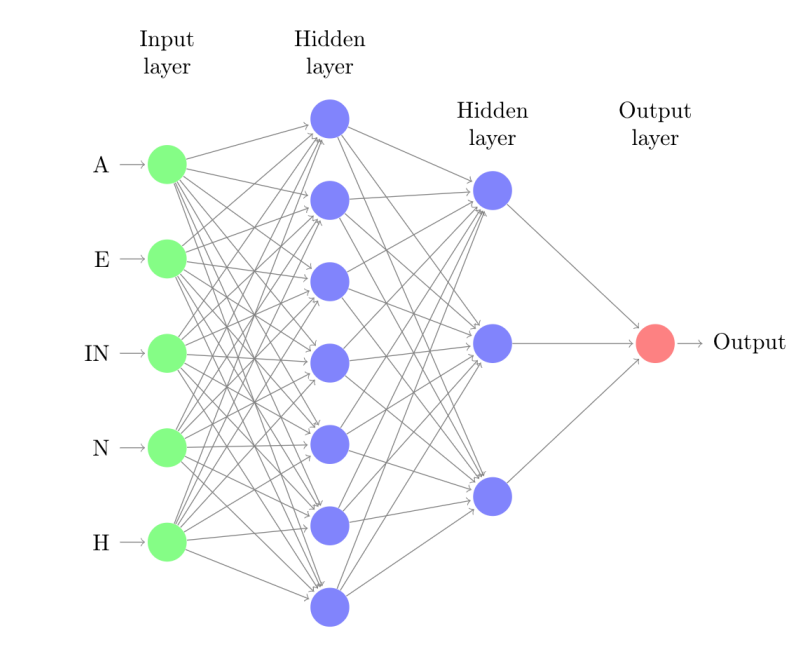

In [17]:
Image(filename = "NN.png", width=1000, height=1000)

### Hefele, John D., et al. “Identifying Earth-Impacting Asteroids Using an Artificial Neural Network.” Astronomy $\&$; Astrophysics, vol. 634, 2020, https://doi.org/10.1051/0004-6361/201935983. 
### Misra, Amit, and S. J. Bus. "Artificial neural network classification of asteroids in the Sloan Digital Sky Survey." AAS/Division for Planetary Sciences Meeting Abstracts# 40. Vol. 40. 2008.

In [18]:
# Build architecture of NN

model = keras.Sequential([
    keras.layers.Input(shape=(5,)),  # input layer (1)
    keras.layers.Dense(7, activation='sigmoid'),  # hidden layer (2)
    keras.layers.Dense(3, activation='sigmoid'),  # hidden layer (3)
    keras.layers.Dense(1, activation='sigmoid') # output layer (4)
])

In [37]:
# Compiler NN with our optimizer and loss function
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [38]:
model.fit(train_df, train_targets, batch_size = 10, epochs=10)

Epoch 1/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.0416 - accuracy: 0.9551
Epoch 2/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.0415 - accuracy: 0.9551
Epoch 3/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.0413 - accuracy: 0.9551
Epoch 4/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.0412 - accuracy: 0.9551
Epoch 5/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.0411 - accuracy: 0.9551
Epoch 6/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.0410 - accuracy: 0.9551
Epoch 7/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.0409 - accuracy: 0.9551
Epoch 8/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.0408 - accuracy: 0.9551
Epoch 9/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.0407 - accuracy: 0.9551
Epoch 10/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.040

In [21]:
test_loss, test_acc = model.evaluate(test_df,  test_targets, verbose=1) 

print('Test accuracy:', test_acc)

172/172 [==============================] - 1s 2ms/step - loss: 0.1640 - accuracy: 0.9593
Test accuracy: 0.9592545032501221


## Model seems too good to be true. Maybe the unbalanced classes are the problem? Recall:
### 683 PHO out of 15635 orbits $\Rightarrow$ about 4.4% of targets will be a 1, while the others are all 0... How then to deal with the problem of massively imballanced classes? 

## We compensate with "stratifying" the positive targets, in an attempt to ensure that both the train and test sets have the same proportion of positive targets in each class

In [22]:
train_df_strat, test_df_strat, train_targets_strat, test_targets_strat = train_test_split(orbits_df, targets, test_size=0.35, random_state=1, stratify=targets)

In [23]:
print("Ratio of original targets:")
print(sum(train_targets) / len(train_targets))
print(sum(test_targets) / len(test_targets))

Ratio of original targets:
0.044873056484943906
0.04074547780010963


In [24]:
print("Ratio of stratified targets:")
print(sum(train_targets_strat) / len(train_targets_strat))
print(sum(test_targets_strat) / len(test_targets_strat))

Ratio of stratified targets:
0.043396969100570754
0.04348620500639503


In [25]:
model.fit(train_df, train_targets, batch_size = 10, epochs=5)

Epoch 1/5
1017/1017 [==============================] - 3s 3ms/step - loss: 0.1771 - accuracy: 0.9551
Epoch 2/5
1017/1017 [==============================] - 2s 2ms/step - loss: 0.1758 - accuracy: 0.9551
Epoch 3/5
1017/1017 [==============================] - 2s 2ms/step - loss: 0.1743 - accuracy: 0.9551
Epoch 4/5
1017/1017 [==============================] - 2s 2ms/step - loss: 0.1727 - accuracy: 0.9551
Epoch 5/5
1017/1017 [==============================] - 3s 3ms/step - loss: 0.1712 - accuracy: 0.9551


In [26]:
test_loss, test_acc = model.evaluate(test_df_strat,  test_targets_strat, verbose=1) 

print('Test accuracy:', test_acc)

172/172 [==============================] - 0s 2ms/step - loss: 0.1923 - accuracy: 0.9565
Test accuracy: 0.9565138220787048


In [27]:
p = model.predict(test_df_strat)

172/172 [==============================] - 0s 2ms/step


In [28]:
type(p)

numpy.ndarray

### Yikes...That's not the problem. If fact, compared to the original targets, not much has changed with the stratification. Maybe the problem is there is too few targets, that is, we need to "undersample" the data corresponding to 0 targets:

In [29]:
from imblearn.datasets import make_imbalance
RANDOM_STATE = 42

In [30]:
# Take all positive targets, but undersample the 0 targets
X, y = make_imbalance(
    orbits_df,
    targets,
    sampling_strategy={0: 2000, 1: 679},
    random_state=RANDOM_STATE,
)

In [31]:
train_df_imb, test_df_imb, train_targets_imb, test_targets_imb = train_test_split(X, y, random_state=RANDOM_STATE)

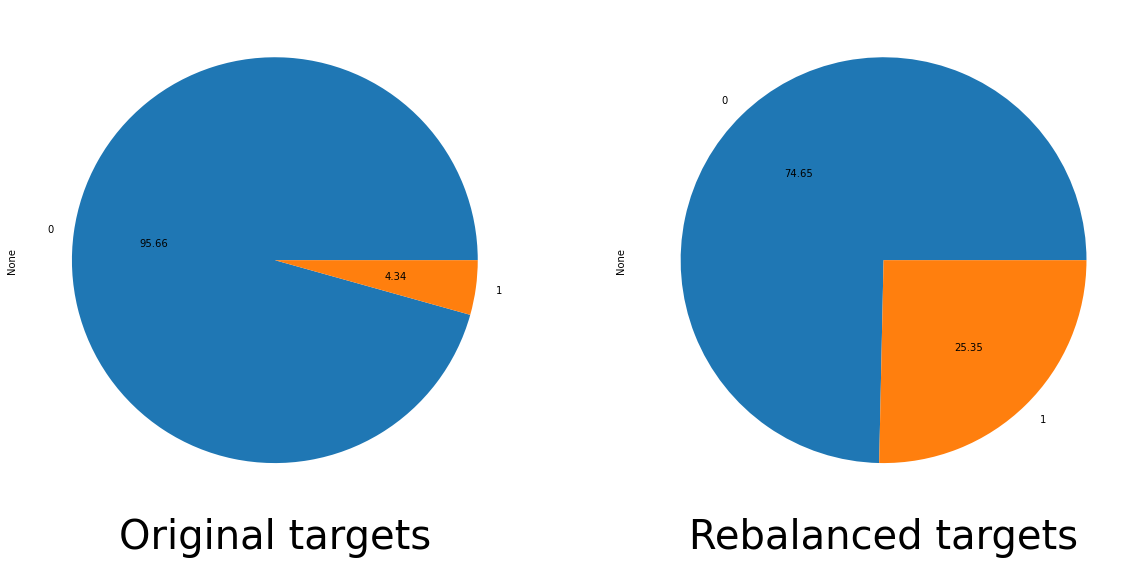

In [32]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=2, figsize=(20, 10))
autopct = "%.2f"
targets.value_counts().plot.pie(autopct=autopct, ax=axs[0])
axs[0].set_xlabel('Original targets', fontsize=40)


y.value_counts().plot.pie(autopct=autopct, ax=axs[1])
# axs[1].set_title("Imbalanced", color = "white");
axs[1].set_xlabel('Rebalanced targets', fontsize=40)
# fig.tight_layout()
plt.rcParams['figure.facecolor'] = 'white'

In [33]:
model.fit(train_df_imb, train_targets_imb, batch_size = 500, epochs=10)

Epoch 1/10
5/5 [==============================] - 0s 2ms/step - loss: 0.6880 - accuracy: 0.7471
Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.7471
Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.6732 - accuracy: 0.7471
Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.6632 - accuracy: 0.7471
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.6527 - accuracy: 0.7471
Epoch 6/10
5/5 [==============================] - 0s 4ms/step - loss: 0.6425 - accuracy: 0.7471
Epoch 7/10
5/5 [==============================] - 0s 6ms/step - loss: 0.6333 - accuracy: 0.7471
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.6258 - accuracy: 0.7471
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.6192 - accuracy: 0.7471
Epoch 10/10
5/5 [==============================] - 0s 5ms/step - loss: 0.6128 - accuracy: 0.7471


In [34]:
test_loss, test_acc = model.evaluate(test_df_imb,  test_targets_imb, verbose=1) 

print('Test accuracy:', test_acc)

21/21 [==============================] - 0s 2ms/step - loss: 0.6122 - accuracy: 0.7448
Test accuracy: 0.7447761297225952


### Finally we arrive at "realistic" performance on the test data, while still training with data representative of the original dataset

In [36]:
import numpy
import sys
numpy.set_printoptions(threshold=sys.maxsize)
p = model.predict(test_df)
p

172/172 [==============================] - 0s 2ms/step


array([[0.10474808],
       [0.04427568],
       [0.08736341],
       [0.02649332],
       [0.02652679],
       [0.03556642],
       [0.08738583],
       [0.10567071],
       [0.02000643],
       [0.03460807],
       [0.02891936],
       [0.10457319],
       [0.02780878],
       [0.07383343],
       [0.02133674],
       [0.08361595],
       [0.11043801],
       [0.09509763],
       [0.03759795],
       [0.0448261 ],
       [0.05730659],
       [0.02766984],
       [0.04052748],
       [0.03206098],
       [0.05957272],
       [0.02528161],
       [0.06781065],
       [0.05403309],
       [0.02159589],
       [0.04290185],
       [0.05047366],
       [0.05564602],
       [0.09784138],
       [0.03730958],
       [0.10998664],
       [0.02164999],
       [0.07535539],
       [0.04870946],
       [0.10120491],
       [0.03199974],
       [0.11010701],
       [0.06405717],
       [0.11050235],
       [0.07762141],
       [0.02893442],
       [0.08002322],
       [0.04027224],
       [0.089